In [1]:
import pandas as pd
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn.impute import KNNImputer
import math
import seaborn as sns
import matplotlib.pyplot
import pylab
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn import tree
import matplotlib.pyplot as plt
import sklearn.model_selection as ms
from sklearn import ensemble
import scipy
import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('train.csv')
testdf = pd.read_csv('test.csv')
df.head()
print(df.shape)

(891, 12)


# Dropping or Dummifying Extraneous Variables

----------------------------PassengerID, Ticket, Name----------------------------

In [3]:
#PassengerID, Ticket, Name are irrelevant

df = df.drop(['PassengerId', 'Ticket', 'Name'], axis=1)

----------------------------Cabin----------------------------

Survived      0
Pclass        0
Sex           0
Age         177
SibSp         0
Parch         0
Fare          0
Cabin       687
Embarked      2
dtype: int64


Ttest_indResult(statistic=9.962587130990059, pvalue=3.090891039654821e-22)


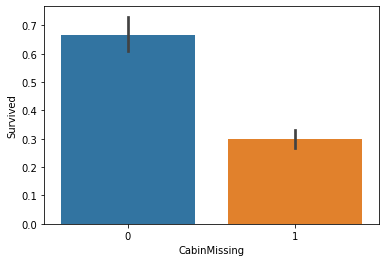

In [4]:
print(df.isna().sum())

print('\n')

#Lots of missingness for Cabin. Lets see if it's telling about surival rates

df['CabinMissing'] = [1 if type(df.Cabin[i]) == float else 0 for i in range(len(df.Cabin))]

print(scipy.stats.ttest_ind(df.Survived[df['CabinMissing']==0],df.Survived[df['CabinMissing']==1]))

sns.barplot(x='CabinMissing', y='Survived', data=df)

#Huge difference in survival rates between those with and without missing cabin.

#Will keep the dummified column and get rid of cabin itself

df = df.drop(['Cabin'], axis=1)

----------------------------Parch----------------------------

Overall Avg. Survival Rate
0.3838383838383838


Parch
0    0.343658
1    0.550847
2    0.500000
3    0.600000
4    0.000000
5    0.200000
6    0.000000
Name: Survived, dtype: float64


Parch
0    678
1    118
2     80
3      5
4      4
5      5
6      1
Name: Survived, dtype: int64


Ttest_indResult(statistic=-4.44366045237527, pvalue=9.960117237213745e-06)


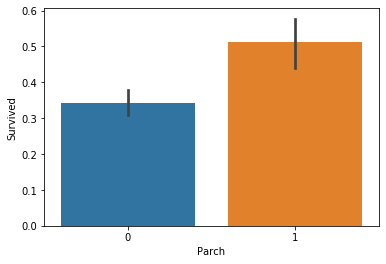

In [5]:
print('Overall Avg. Survival Rate')
print(len(df[df['Survived']==1])/len(df))

print('\n')
print(df.groupby('Parch').mean()['Survived'])
print('\n')
print(df.groupby('Parch').count()['Survived'])
print('\n')

#Survival rate doesn't really increase with each Parch number
#But it does seem to be different at 0 Parches vs 1+ Parch
#Will dummify

df['Parch'] = [1 if df.Parch[i]>0 else 0 for i in range(len(df.Parch))]

#Will test difference in survival rates for parch vs. no parch

print(scipy.stats.ttest_ind(df.Survived[df['Parch']==0],df.Survived[df['Parch']==1]))

#pvalue < 0.05

sns.barplot(x='Parch', y='Survived', data=df)

----------------------------SibSp----------------------------

In [6]:
print(df.groupby('SibSp').mean()['Survived'])
print('\n')
print(df.groupby('SibSp').count()['Survived'])

# It's obviously not a linear progression
# I will dummify 0, 1, and 2 (3+ will be the removed column)

df['0Sib'] = [1 if df.SibSp[i]==0 else 0 for i in range(len(df.SibSp))]
df['1Sib'] = [1 if df.SibSp[i]==1 else 0 for i in range(len(df.SibSp))]
df['2Sib'] = [1 if df.SibSp[i]==2 else 0 for i in range(len(df.SibSp))]

df = df.drop(['SibSp'], axis=1)

SibSp
0    0.345395
1    0.535885
2    0.464286
3    0.250000
4    0.166667
5    0.000000
8    0.000000
Name: Survived, dtype: float64


SibSp
0    608
1    209
2     28
3     16
4     18
5      5
8      7
Name: Survived, dtype: int64


# Imputing Missing Data

----------------------------Embarked----------------------------

In [7]:
print(df.isna().sum())

print('\n')

print(df.Embarked.value_counts())

print('\n')

#The vast majority of Embarked values are 'S', so we will impute with that, since there's only 2 missing.

for i in range(len(df.Embarked)):
    if pd.isna(df.Embarked[i]):
        df.Embarked[i] = 'S'

Survived          0
Pclass            0
Sex               0
Age             177
Parch             0
Fare              0
Embarked          2
CabinMissing      0
0Sib              0
1Sib              0
2Sib              0
dtype: int64


S    644
C    168
Q     77
Name: Embarked, dtype: int64




----------------------------Age----------------------------

Survived          0
Pclass            0
Sex               0
Age             177
Parch             0
Fare              0
Embarked          0
CabinMissing      0
0Sib              0
1Sib              0
2Sib              0
dtype: int64


Ttest_indResult(statistic=2.7606993230995345, pvalue=0.005886534840075563)


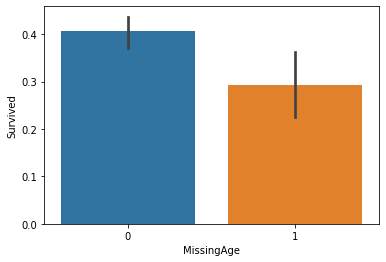

In [8]:
print(df.isna().sum())
print('\n')

#Like Cabin, will dummify Age missingness

df['MissingAge'] = [1 if np.isnan(df.Age[i]) else 0 for i in range(len(df.Age))]

#Will run a 2-sample t-test to see if age missingness effects survival rate

print(scipy.stats.ttest_ind(df.Survived[df['MissingAge']==0],df.Survived[df['MissingAge']==1]))

#significant difference in survival rate (pvalue < 0.05)

sns.barplot(x='MissingAge', y='Survived', data=df)

In [9]:
df.corr()['Age']['Survived']

#No obvious linear correlation between Age and survival

-0.07722109457217737

In [10]:
#I want to see if I dummify ages by 10s of years, if we can see any trend in survival rate as the age increases

dfage = df.copy()

dfage['zero-nine'] = [1 if dfage.Age[i] < 10 else 0 for i in range(len(dfage.Age))]
dfage['ten-nineteen'] = [1 if (dfage.Age[i] < 20 and dfage.Age[i] >= 10)  else 0 for i in range(len(dfage.Age))]
dfage['twenty-twentynine'] = [1 if (dfage.Age[i] < 30 and dfage.Age[i] >= 20)  else 0 for i in range(len(dfage.Age))]
dfage['thirty-nine'] = [1 if (dfage.Age[i] < 40 and dfage.Age[i] >= 30)  else 0 for i in range(len(dfage.Age))]
dfage['fourty-nine'] = [1 if (dfage.Age[i] < 50 and dfage.Age[i] >= 40)  else 0 for i in range(len(dfage.Age))]
dfage['fifty-nine'] = [1 if (dfage.Age[i] < 60 and dfage.Age[i] >= 50)  else 0 for i in range(len(dfage.Age))]
dfage['sixty-nine'] = [1 if (dfage.Age[i] < 70 and dfage.Age[i] >= 60)  else 0 for i in range(len(dfage.Age))]
dfage['seventy+'] = [1 if dfage.Age[i]>= 70 else 0 for i in range(len(dfage.Age))]

print('Proportion of those ages 0-9 that survived: ' + str(sum(df.Survived[dfage['zero-nine']==1])/sum(dfage['zero-nine'])) + '     Sample Size: ' + str(sum(dfage['zero-nine'])))
print('Proportion of those ages 10-19 that survived: ' + str(sum(df.Survived[dfage['ten-nineteen']==1])/sum(dfage['ten-nineteen'])) + '     Sample Size: ' + str(sum(dfage['ten-nineteen'])))
print('Proportion of those ages 20-29 that survived: ' + str(sum(df.Survived[dfage['twenty-twentynine']==1])/sum(dfage['twenty-twentynine'])) + '     Sample Size: ' + str(sum(dfage['twenty-twentynine'])))
print('Proportion of those ages 30-39 that survived: ' + str(sum(df.Survived[dfage['thirty-nine']==1])/sum(dfage['thirty-nine'])) + '     Sample Size: ' + str(sum(dfage['thirty-nine'])))
print('Proportion of those ages 40-49 that survived: ' + str(sum(df.Survived[dfage['fourty-nine']==1])/sum(dfage['fourty-nine'])) + '     Sample Size: ' + str(sum(dfage['fourty-nine'])))
print('Proportion of those ages 50-59 that survived: ' + str(sum(df.Survived[dfage['fifty-nine']==1])/sum(dfage['fifty-nine'])) + '     Sample Size: ' + str(sum(dfage['fifty-nine'])))
print('Proportion of those ages 60-69 that survived: ' + str(sum(df.Survived[dfage['sixty-nine']==1])/sum(dfage['sixty-nine'])) + '     Sample Size: ' + str(sum(dfage['sixty-nine'])))
print('Proportion of those ages 70+ that survived: ' + str(sum(df.Survived[dfage['seventy+']==1])/sum(dfage['seventy+'])) + '     Sample Size: ' + str(sum(dfage['seventy+'])))

# The difference is all concentrated in the much lower and much higher age. 
# Change in age looks like it has a negligible impact from 10-60
# We can drop the age variable, but let's drill in further to see if we can dummify some cutoff points

Proportion of those ages 0-9 that survived: 0.6129032258064516     Sample Size: 62
Proportion of those ages 10-19 that survived: 0.4019607843137255     Sample Size: 102
Proportion of those ages 20-29 that survived: 0.35     Sample Size: 220
Proportion of those ages 30-39 that survived: 0.437125748502994     Sample Size: 167
Proportion of those ages 40-49 that survived: 0.38202247191011235     Sample Size: 89
Proportion of those ages 50-59 that survived: 0.4166666666666667     Sample Size: 48
Proportion of those ages 60-69 that survived: 0.3157894736842105     Sample Size: 19
Proportion of those ages 70+ that survived: 0.14285714285714285     Sample Size: 7


In [11]:
dfage = df.copy()

#Overall survival rate for training data
survivor_proportion = len(df[df['Survived']==1]) / len(df)

print('Percent of overall survivors ' + str(survivor_proportion))
print('\n')

#survival percentage by each age

for i in range(20):
    if len(df[(df['Age']==i)]) != 0: 
        print('Number of Passeners age ' + str(i) + ":    " + str(round(len(df[(df['Age']==i) & (df['Survived']==1)]) / len(df[(df['Age']==i)]),4)) + '                 Sample size = ' + str(len(df[(df['Age']==i)])))
    else:
        print('Age ' + str(i) + ' has no samples')

print('\n')
print('-'*50)        
print('\n')
        
for i in range(55,int(df.Age.max()+1)):
    if len(df[(df['Age']==i)]) != 0: 
        print('Number of Passeners age ' + str(i) + ":    " + str(round(len(df[(df['Age']==i) & (df['Survived']==1)]) / len(df[(df['Age']==i)]),4)) + '                 Sample size = ' + str(len(df[(df['Age']==i)])))
    else:
        print('Age ' + str(i) + ' has no samples')
        
print('\n')

# #Not extremely conclusive, but some evidence that passengers age 6 or less have a higher survival rate
# #We will try a dummified column of Age 6 or less.

df['Age6-'] = [1 if df.Age[i]<=6 else 0 for i in range(len(df.Age))]

#1 of 12 passengers age 64 and up survived
#For the older side, we will set a cutoff point of 64 years or older

df['Age64+'] = [1 if df.Age[i]>=64 else 0 for i in range(len(df.Age))]

print('\n')

print('2 Sample t-test for Age 6 and under having higher survival rate')
print(scipy.stats.ttest_ind(df.Survived[df['Age6-']==0],df.Survived[df['Age6-']==1]))

print('2 Sample t-test for Age 64 and above having lower survival rate')
print(scipy.stats.ttest_ind(df.Survived[df['Age64+']==0],df.Survived[df['Age64+']==1]))

#We have a dummified column for age missingness and age cutoffs, now we can drop the original age var

df = df.drop(['Age'], axis=1)
    

Percent of overall survivors 0.3838383838383838


Age 0 has no samples
Number of Passeners age 1:    0.7143                 Sample size = 7
Number of Passeners age 2:    0.3                 Sample size = 10
Number of Passeners age 3:    0.8333                 Sample size = 6
Number of Passeners age 4:    0.7                 Sample size = 10
Number of Passeners age 5:    1.0                 Sample size = 4
Number of Passeners age 6:    0.6667                 Sample size = 3
Number of Passeners age 7:    0.3333                 Sample size = 3
Number of Passeners age 8:    0.5                 Sample size = 4
Number of Passeners age 9:    0.25                 Sample size = 8
Number of Passeners age 10:    0.0                 Sample size = 2
Number of Passeners age 11:    0.25                 Sample size = 4
Number of Passeners age 12:    1.0                 Sample size = 1
Number of Passeners age 13:    1.0                 Sample size = 2
Number of Passeners age 14:    0.5                 

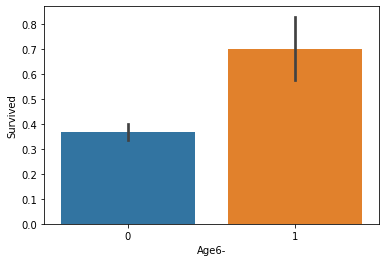

In [12]:
sns.barplot(x='Age6-', y='Survived', data=df)

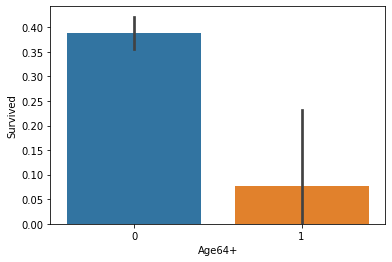

In [13]:
sns.barplot(x='Age64+', y='Survived', data=df)

In [14]:
df.isna().sum()

#Missing data is good to go

Survived        0
Pclass          0
Sex             0
Parch           0
Fare            0
Embarked        0
CabinMissing    0
0Sib            0
1Sib            0
2Sib            0
MissingAge      0
Age6-           0
Age64+          0
dtype: int64

# Handling Categorical Data

-------------------------Sex-------------------------

In [15]:
df.Sex = [0 if i=='male' else 1 for i in df.Sex]

-------------------------Embark-------------------------

In [16]:
print(df.groupby(['Embarked']).mean()['Survived'])

#Seems to make a difference. Will dummify and run a hypothesis test

Embarked
C    0.553571
Q    0.389610
S    0.339009
Name: Survived, dtype: float64


In [17]:
#We will dummify these and see if they 

embarkdums = pd.get_dummies(df.Embarked)
df['Q'] = embarkdums['Q']
df['S'] = embarkdums['S']
df['C'] = embarkdums['C']

print('Q: ' + str(scipy.stats.ttest_ind(df.Survived[df['Q']==0],df.Survived[df['Q']==1])))
print('S: ' + str(scipy.stats.ttest_ind(df.Survived[df['S']==0],df.Survived[df['S']==1])))
print('C: ' + str(scipy.stats.ttest_ind(df.Survived[df['C']==0],df.Survived[df['C']==1])))

#2 of the 3 yield statistically significant survival rates, so we will use them.

df = df.drop(['Q'], axis=1)

df = df.drop(['Embarked'], axis=1)

Q: Ttest_indResult(statistic=-0.10884091138160804, pvalue=0.9133532352434202)
S: Ttest_indResult(statistic=4.513807692270816, pvalue=7.223240983688172e-06)
C: Ttest_indResult(statistic=-5.088809978331468, pvalue=4.39715132980687e-07)


----------------------------Sanity Check----------------------------

In [18]:
df.corr()

,Survived,Pclass,Sex,Parch,Fare,CabinMissing,0Sib,1Sib,2Sib,MissingAge,Age6-,Age64+,S,C
Survived,1.000000,-0.338481,0.543351,0.147408,0.257307,-0.316912,-0.115867,0.173076,0.029796,-0.092197,0.154447,-0.076793,-0.149683,0.168240
Pclass,-0.338481,1.000000,-0.131900,-0.027526,-0.549500,0.725541,0.076009,-0.166435,0.010455,0.172933,0.075072,-0.100953,0.074053,-0.243292
Sex,0.543351,-0.131900,1.000000,0.247523,0.182333,-0.140391,-0.203203,0.179339,0.042182,-0.055215,0.067649,-0.089764,-0.119224,0.082853
Parch,0.147408,-0.027526,0.247523,1.000000,0.237717,-0.089136,-0.420233,0.223798,0.080037,-0.147163,0.409248,-0.002365,0.032821,0.032550
Fare,0.257307,-0.549500,0.182333,0.237717,1.000000,-0.482075,-0.192190,0.133121,0.070901,-0.100707,-0.005016,0.035489,-0.162184,0.269335
CabinMissing,-0.316912,0.725541,-0.140391,-0.089136,-0.482075,1.000000,0.075769,-0.133319,0.006289,0.144111,0.009093,-0.067357,0.101139,-0.208528
0Sib,-0.115867,0.076009,-0.203203,-0.420233,-0.192190,0.075769,1.000000,-0.811408,-0.264017,0.097998,-0.216471,0.042806,-0.004412,-0.034759
1Sib,0.173076,-0.166435,0.179339,0.223798,0.133121,-0.133319,-0.811408,1.000000,-0.099714,-0.103021,0.058954,-0.023181,-0.038742,0.092043
2Sib,0.029796,0.010455,0.042182,0.080037,0.070901,0.006289,-0.264017,-0.099714,1.000000,-0.041313,0.101388,-0.021918,-0.018741,0.011850
MissingAge,-0.092197,0.172933,-0.055215,-0.147163,-0.100707,0.144111,0.097998,-0.103021,-0.041313,1.000000,-0.117494,-0.060585,-0.241480,0.033270


In [19]:
#Final thought...

df.sort_values(by = 'Fare', ascending=False).head()

# There is obvious multicolinearity with Pclass and CabinMissing, could test different number of these features

,Survived,Pclass,Sex,Parch,Fare,CabinMissing,0Sib,1Sib,2Sib,MissingAge,Age6-,Age64+,S,C
258,1,1,1,0,512.3292,1,1,0,0,0,0,0,0,1
737,1,1,0,0,512.3292,0,1,0,0,0,0,0,0,1
679,1,1,0,1,512.3292,0,1,0,0,0,0,0,0,1
88,1,1,1,1,263.0000,0,0,0,0,0,0,0,1,0
27,0,1,0,1,263.0000,0,0,0,0,0,0,0,1,0


# Modeling Prep

In [20]:
#Seperating our target variable

Survived = df['Survived']
df = df.drop(['Survived'], axis=1)

In [21]:
#Getting our test dataframe to match the changes to our training dataframe

testdf = pd.read_csv('test.csv')
testdf = testdf.drop(['PassengerId', 'Name', 'Ticket'], axis=1)
testdf.Sex = [0 if i=='male' else 1 for i in testdf.Sex]

testdf['Age6-'] = [1 if testdf.Age[i]<=6 else 0 for i in range(len(testdf.Age))]
testdf['Age64+'] = [1 if testdf.Age[i]>=64 else 0 for i in range(len(testdf.Age))]
testdf['MissingAge'] = [1 if np.isnan(testdf.Age[i]) else 0 for i in range(len(testdf.Age))]
testdf = testdf.drop(['Age'], axis=1)

testdf['CabinMissing'] = [1 if type(testdf.Cabin[i]) == float else 0 for i in range(len(testdf.Cabin))]
testdf = testdf.drop(['Cabin'], axis=1)

testembarkdums = pd.get_dummies(testdf.Embarked)
testembarkdums = testembarkdums.drop(['Q'], axis=1)
testdf['C'] = testembarkdums['C']
testdf['S'] = testembarkdums['S']
testdf = testdf.drop(['Embarked'], axis=1)

fareimpute = testdf.groupby('Pclass').mean()['Fare']
for i in range(len(testdf.Fare)):
    if pd.isna(testdf.Fare[i]):
        testdf.Fare[i] = fareimpute.loc[testdf.Pclass[i]]

testdf['0Sib'] = [1 if testdf.SibSp[i]==0 else 0 for i in range(len(testdf.SibSp))]
testdf['1Sib'] = [1 if testdf.SibSp[i]==1 else 0 for i in range(len(testdf.SibSp))]
testdf['2Sib'] = [1 if testdf.SibSp[i]==2 else 0 for i in range(len(testdf.SibSp))]
testdf = testdf.drop(['SibSp'], axis=1)

In [50]:
#We can toggle what variables we don't want

cols = [i for i in df.columns if i not in ['Fare']]

df = df[cols]
testdf = testdf[cols]

In [24]:
#First function will train our model on 80% of data and try it on the test data

X_train, X_test, y_train, y_test = train_test_split(df, Survived, test_size=0.2, random_state=0)

def split_get_error(X_train, y_train, X_test, y_test, model, show = True): #call what we got from the split
    model.fit(X_train, y_train) #fit the model
    train_accuracy = model.score(X_train, y_train) #how it performs on the data it was trained on
    test_accuracy  = model.score(X_test, y_test) #how it performs on data we held out
    if show: #we can change the argument to show=False if we don't want to print the errors
        print("The training error is: %.5f" %train_accuracy)
        print("The test     error is: %.5f" %test_accuracy)
    return ('-'*50)

#Second function will train our model on all the data. Accuracy will be on the same training data

def get_error(x, y, model, show = True): #call what we got from the split
    model.fit(x,y) #fit the model
    train_accuracy = model.score(x,y) #how it performs on the data it was trained on
    if show: #we can change the argument to show=False if we don't want to print the errors
        print("The training error is: %.5f" %train_accuracy)
    return ('-'*50)

# Logistic Regression

In [25]:
logistic = LogisticRegression(C=10000)
logistic.fit(df, Survived)

print(split_get_error(X_train, y_train, X_test, y_test, logistic))
print(get_error(df, Survived, logistic))

preds = logistic.predict(testdf)
Id = [i for i in range(892,1310)]
testdict = {'PassengerId': Id, 'Survived': preds}
finaldf = pd.DataFrame(data=testdict).set_index('PassengerId')
finaldf.to_csv('fulltitaniclogistic.csv')

preds = logistic.predict(testdf)
Id = [i for i in range(892,1310)]
testdict = {'PassengerId': Id, 'Survived': preds}
finaldf = pd.DataFrame(data=testdict).set_index('PassengerId')
finaldf.to_csv('splittitaniclogistic.csv')

The training error is: 0.82022
The test     error is: 0.80447
--------------------------------------------------
The training error is: 0.81481
--------------------------------------------------


# Unpruned Decision Trees

In [26]:
tree_model = tree.DecisionTreeClassifier() # store the model type we'll be using in a variable name
print(split_get_error(X_train, y_train, X_test, y_test, tree_model))
print(get_error(df, Survived, tree_model))

# Tree is way overfit to the training data
# Will prune it back

The training error is: 0.93820
The test     error is: 0.79888
--------------------------------------------------
The training error is: 0.93939
--------------------------------------------------


# Pruned Decision Trees

In [40]:
import warnings
warnings.filterwarnings('ignore')

grid_para_tree = {'criterion': ['gini', 'entropy'], 'max_depth': range(1, 30), 'min_samples_split': range(1,30), 'splitter': ['best', 'random']}

#Tuning TWO hyperparameters: criterion, tree depth

grid_search_tree_split = %time ms.GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1).fit(X_train, y_train)
grid_search_tree = %time ms.GridSearchCV(tree_model, grid_para_tree, cv=5, scoring='accuracy', n_jobs=-1).fit(df, Survived)
#run the grid search
print('-'*50)
print('Split Tree:')
print('Best parameters: '+ str(grid_search_tree_split.best_params_))
print('The best score is %.4f' %grid_search_tree_split.best_score_)
print('The training accuracy is %.4f' %(grid_search_tree_split.best_estimator_.score(X_train, y_train)))
print('The testing accuracy is %.4f' %(grid_search_tree_split.best_estimator_.score(X_test, y_test)))
print('-'*50)
print('Full Tree:')
print('Best parameters: '+ str(grid_search_tree.best_params_))
print('The best score is %.4f' %grid_search_tree.best_score_)
print('The training accuracy is %.4f' %(grid_search_tree.best_estimator_.score(df, Survived)))


preds = grid_search_tree_split.predict(testdf)
Id = [i for i in range(892,1310)]
testdict = {'PassengerId': Id, 'Survived': preds}
finaldf = pd.DataFrame(data=testdict).set_index('PassengerId')
finaldf.to_csv('splittree.csv')

preds = grid_search_tree.predict(testdf)
Id = [i for i in range(892,1310)]
testdict = {'PassengerId': Id, 'Survived': preds}
finaldf = pd.DataFrame(data=testdict).set_index('PassengerId')
finaldf.to_csv('fulltree.csv')

CPU times: user 23.5 s, sys: 615 ms, total: 24.2 s
Wall time: 37.4 s
CPU times: user 27 s, sys: 728 ms, total: 27.7 s
Wall time: 39.8 s
--------------------------------------------------
Split Tree:
Best parameters: {'criterion': 'entropy', 'max_depth': 5, 'min_samples_split': 2, 'splitter': 'random'}
The best score is 0.8216
The training accuracy is 0.8357
The testing accuracy is 0.8156
--------------------------------------------------
Full Tree:
Best parameters: {'criterion': 'entropy', 'max_depth': 9, 'min_samples_split': 3, 'splitter': 'random'}
The best score is 0.8283
The training accuracy is 0.8698


# Random Forest

In [51]:
randomForest = ensemble.RandomForestClassifier()

grid_para_forest = {
    'criterion': ['gini', 'entropy'], # criterion = are we trying to optimize gini or entropy
    'max_depth': range(1, 31), # depth = varying max tree_depths
    'n_estimators': range(10, 110, 10), # n_estimators = number of trees in the forest
    'max_features': range(1,len(df.columns)) # n_estimators = number of trees in the forest
}

grid_search_forest_split = ms.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=3, n_jobs=-1)
%time grid_search_forest_split.fit(X_train, y_train)

grid_search_forest = ms.GridSearchCV(randomForest, grid_para_forest, scoring='accuracy', cv=3, n_jobs=-1)
%time grid_search_forest.fit(df, Survived)

print('Split Forest:')
print(grid_search_forest_split.best_params_)
print(grid_search_forest_split.best_score_)
print("The training accuracy is: %.5f" % (grid_search_forest_split.best_estimator_.score(X_train, y_train)))
print("The test     accuracy is: %.5f" % (grid_search_forest_split.best_estimator_.score(X_test, y_test)))
print('-'*50)
print('Full Forest:')
print(grid_search_forest.best_params_)
print(grid_search_forest.best_score_)
print("The training accuracy is: %.5f" % (grid_search_forest.best_estimator_.score(df, Survived)))

preds = grid_search_forest_split.predict(testdf)
Id = [i for i in range(892,1310)]
testdict = {'PassengerId': Id, 'Survived': preds}
finaldf = pd.DataFrame(data=testdict).set_index('PassengerId')
finaldf.to_csv('splitforest.csv')

preds = grid_search_forest.predict(testdf)
Id = [i for i in range(892,1310)]
testdict = {'PassengerId': Id, 'Survived': preds}
finaldf = pd.DataFrame(data=testdict).set_index('PassengerId')
finaldf.to_csv('fullforest.csv')

CPU times: user 2min 5s, sys: 4.35 s, total: 2min 10s
Wall time: 31min 5s
CPU times: user 1min 45s, sys: 4.17 s, total: 1min 49s
Wall time: 10min 10s
Split Forest:
{'criterion': 'entropy', 'max_depth': 5, 'max_features': 4, 'n_estimators': 60}
0.8300889976243662
The training accuracy is: 0.84972
The test     accuracy is: 0.83799
--------------------------------------------------
Full Forest:
{'criterion': 'gini', 'max_depth': 5, 'max_features': 6, 'n_estimators': 20}
0.8271604938271605
The training accuracy is: 0.84063


ValueError: Number of features of the model must match the input. Model n_features is 13 and input n_features is 12 

In [ ]:
1+1